# from allcools page: https://lhqing.github.io/ALLCools/cell_level/step_by_step/100kb/04a-PreclusteringAndClusterEnrichedFeatures-mCH.html

Preclustering and Cluster Enriched Features
Purpose
The purpose of this step is to perform a simple pre-clustering using the highly variable features to get a pre-clusters labeling. We then select top enriched features for each cluster (CEF) for further analysis.



Input¶
HVF adata file.

Output
HVF adata file with pre-clusters and CEF annotated.



In [2]:
#!pip install openTSNE


In [7]:
#conda install -c conda-forge opentsne


Retrieving notices: ...working... done
done
Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::_anaconda_depends==2024.02=py311_mkl_1
done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.7.1



## Package Plan ##

  environment location: /share/lasallelab/Ensi/anaconda3

  added / updated specs:
    - opentsne


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.7.4   |       hbcca054_0         151 KB  conda-forge
    certifi-2024.7.4           |     pyhd8ed1ab_0         156 KB  conda-forge
    openssl-3.3.1         

In [1]:
from openTSNE import TSNEEmbedding, affinity, initialization


In [4]:
#!pip install scanpy


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.5 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=05d7d9dcb5043e084eba9e68fd8ebc8e7c479593420f5da8b8dc1b179059a877
  Stored in directory: /home/ehabibi/.cache/pip/wheels/5c/1b/4d/111d73980c5c6a8e5e5905a19eccc34296cb359cac54c6c5b9
Successfully built session-info


In [ ]:
#conda install -c conda-forge leidenalg

In [2]:
import leidenalg

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
from ALLCools.clustering import cluster_enriched_features, significant_pc_test, log_scale
from ALLCools.clustering import log_scale


In [2]:
sns.set_context(context='notebook', font_scale=1.3)

In [3]:
adata_path = 'mCH.HVF.h5ad'

var_dim = 'chrom100k'
# Cluster Enriched Features analysis
top_n=500
alpha=0.05
stat_plot=True

# you may provide a pre calculated cluster version. 
# If None, will perform basic clustering using parameters below.
cluster_col = None  

# These parameters only used when cluster_col is None
k=25
resolution= 0.50
cluster_plot=True

In [4]:


adata = anndata.read_h5ad(adata_path)

adata

AnnData object with n_obs × n_vars = 46 × 23803
    var: 'chrom', 'end', 'start', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select'

adata.X is already log transformed, skip log step.
7 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (46, 30) to (46, 7)


/home/ehabibi/.conda/envs/allcools/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


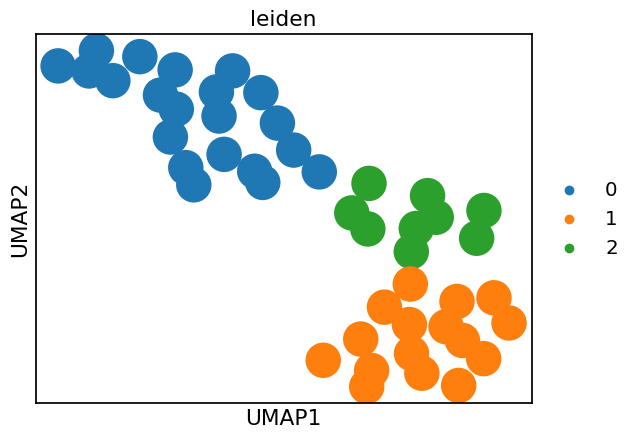

In [10]:
if cluster_col is None:
    # IMPORTANT
    # put the unscaled matrix in adata.raw
    adata.raw = adata
    log_scale(adata)
    
    sc.tl.pca(adata, n_comps=30)
    significant_pc_test(adata, p_cutoff=0.1, update=True)
    
    sc.pp.neighbors(adata, n_neighbors=k)
    sc.tl.leiden(adata, resolution=resolution)
    
    if cluster_plot:
        sc.tl.umap(adata)
        sc.pl.umap(adata, color='leiden')
    
    # return to unscaled X, CEF need to use the unscaled matrix
    adata = adata.raw.to_adata()
    
    cluster_col = 'leiden'

In [11]:
#save plot
plt.savefig(f"mch_precluster_{var_dim}_pooledonly.png")


<Figure size 640x480 with 0 Axes>

Found 3 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 4 unique features


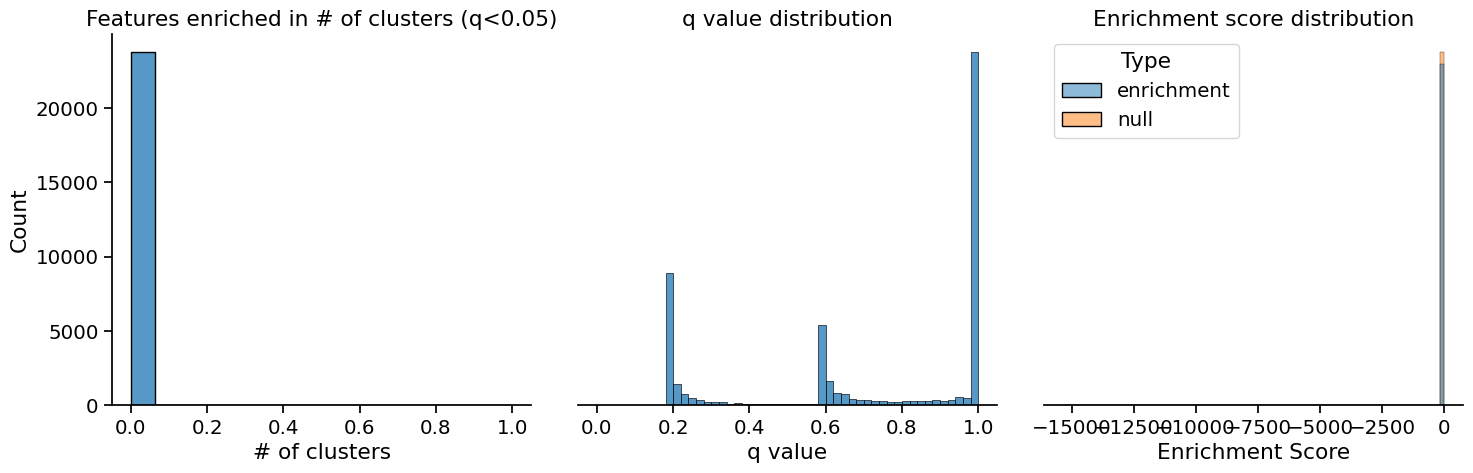

In [12]:
# cluster enriched features
cluster_enriched_features(adata,
                          cluster_col=cluster_col,
                          top_n=top_n,
                          alpha=alpha,
                          stat_plot=True)

In [13]:
# save 
plt.savefig(f"mch_CEF_alpha0.05topn500_{var_dim}_pooled.png")


<Figure size 640x480 with 0 Axes>

In [14]:
# save adata
adata.write_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 46 × 23803
    obs: 'leiden'
    var: 'chrom', 'end', 'start', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'leiden_enriched_features'
    uns: 'log', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'leiden_feature_enrichment'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'